In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, InputLayer
from skimage.metrics import structural_similarity as ssim

#### Melakukan read data berdasarkan file path yang telah ditentukan

In [2]:
folder_path = 'A_23'
image_files = [f for f in os.listdir(folder_path)]

In [3]:
len(image_files)

1074

#### Menampilkan gambar dari data yang telah dibaca, agar setidaknya kita memiliki gambaran bagaimana gambar yang akan diproses nantinya.

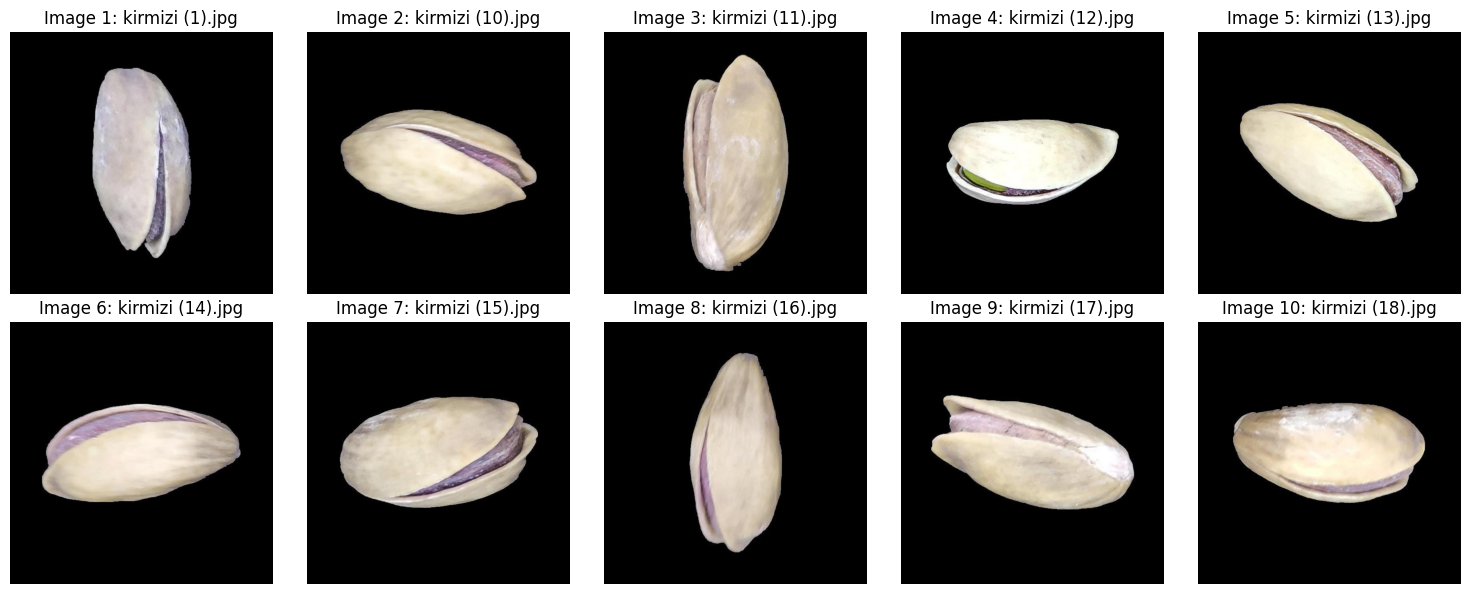

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    img_path = os.path.join(folder_path, image_files[i])
    
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    ax = axes[i // 5, i % 5]
    ax.imshow(img_rgb)
    ax.axis('off')
    ax.set_title(f'Image {i+1}: {image_files[i]}')

plt.tight_layout()

#### Melakukan pengecekan size beserta dimensi dari gambar tersebut.

In [5]:
def analyze_unique_image_dimensions(image_files, folder_path):
    unique_sizes = set()
    for image_file in image_files:
        img_path = os.path.join(folder_path, image_file)
        
        img = cv2.imread(img_path)
        
        if img is not None:
            height, width, channels = img.shape
            unique_sizes.add((height, width, channels))
    
    for size in unique_sizes:
        print(f'Dimensi: {size[0]}x{size[1]}x{size[2]}')

analyze_unique_image_dimensions(image_files, folder_path)

Dimensi: 600x600x3


#### Berdasarkan hasil pengecekan size serta dimensi tersebut, dapat dilihat bahwa seluruh gambar memiliki size yang sama, dan setiap gambar memiliki 3 channel, yang menandakan bahwa gambar tersebut adalah RGB, hal ini penting diketahui, agar kita bisa mengecek bagaimana distribusi RGB dari gambar tersebut. Maka dari itu tahap selanjutnya, saya akan melakukan pengecekan distribusi RGB 3 gambar pertama.

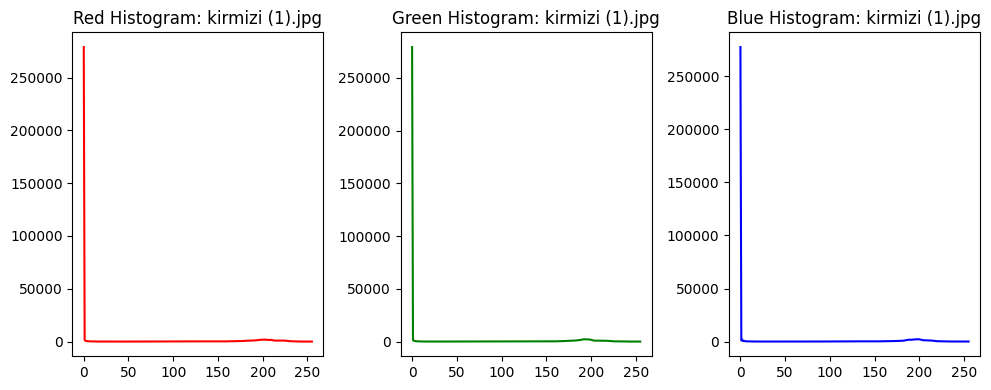

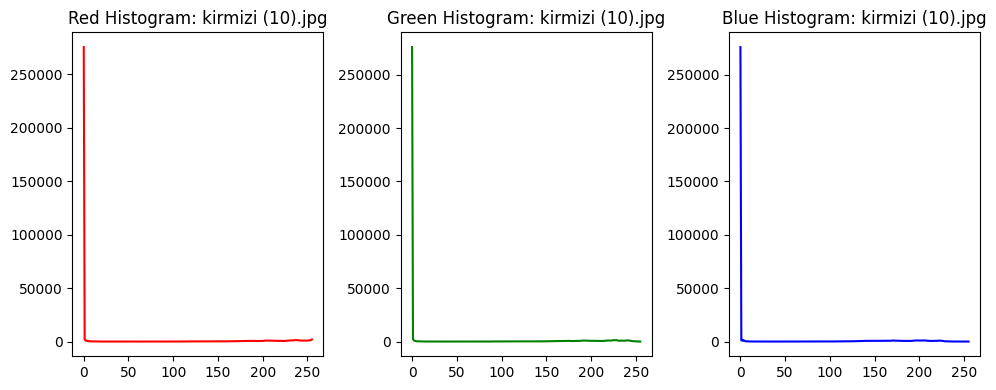

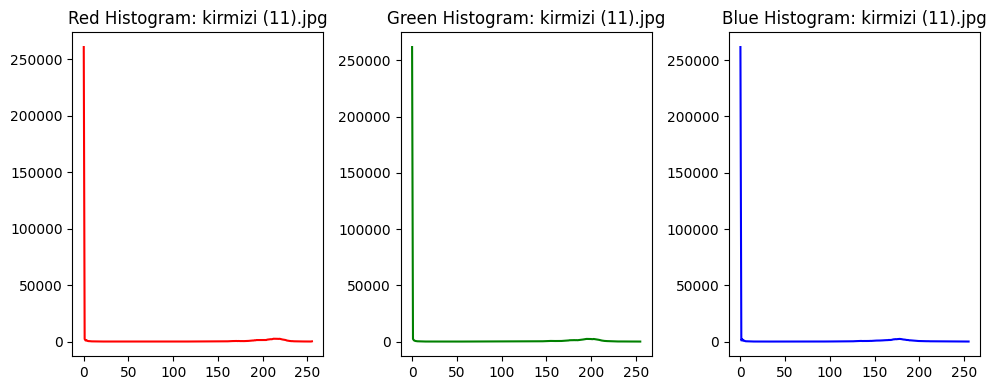

In [6]:
for i in range(3):
    img_path = os.path.join(folder_path, image_files[i])
    
    img = cv2.imread(img_path)
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    hist_red = cv2.calcHist([img_rgb], [0], None, [256], [0, 256])
    hist_green = cv2.calcHist([img_rgb], [1], None, [256], [0, 256])
    hist_blue = cv2.calcHist([img_rgb], [2], None, [256], [0, 256])
    
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot(hist_red, color='red')
    plt.title(f"Red Histogram: {image_files[i]}")
    
    plt.subplot(1, 3, 2)
    plt.plot(hist_green, color='green')
    plt.title(f"Green Histogram: {image_files[i]}")
   
    plt.subplot(1, 3, 3)
    plt.plot(hist_blue, color='blue')
    plt.title(f"Blue Histogram: {image_files[i]}")
    
    plt.tight_layout()
    plt.show()

#### Dikarenakan distribusi plot untuk RGB dari 3 gambar pertama cenderung berada di angka 0 semua, maka hal ini tidak akan menjadi masalah, dikarenakan distribusi RGB untuk setiap gambar itu sama. Pada data kali ini, kita juga tidak perlu mengubah gambar menjadi grayscale, hal tersebut diakrenakan warna tidak akan begitu mempengaruhi model begitu signifikan.


#### Pada tahap EDA selanjutnya, saya akan melakukan pengecekan distribusi pencahayaan sebagai berikut.

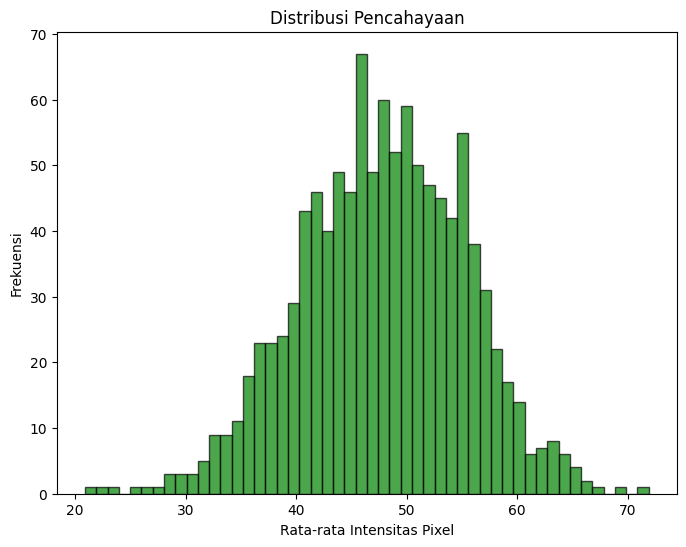

In [7]:
def calculate_intensity_distribution(image_files, folder_path):
    intensities = []
    for image_file in image_files:
        img_path = os.path.join(folder_path, image_file)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        avg_intensity = np.mean(img_rgb)
        intensities.append(avg_intensity)
    return intensities

def plot_histogram_for_lighting(image_files, folder_path):
    lighting_intensities = []

    intensities = calculate_intensity_distribution(image_files, folder_path)
    lighting_intensities.extend(intensities)
    
    plt.figure(figsize=(8, 6))
    plt.hist(lighting_intensities, bins=50, alpha=0.7, color='green', edgecolor='black')
    plt.title(f"Distribusi Pencahayaan")
    plt.xlabel("Rata-rata Intensitas Pixel")
    plt.ylabel("Frekuensi")
    plt.show()


plot_histogram_for_lighting(image_files, folder_path)


#### Distribusi pencahayaan dalam dataset Anda menunjukkan bahwa sebagian besar gambar memiliki intensitas menengah, dengan beberapa gambar yang lebih gelap atau lebih terang. Ini penting dalam Exploratory Data Analysis (EDA) karena memastikan bahwa dataset Anda memiliki pencahayaan yang seimbang, yang dapat mempermudah pemrosesan gambar dan pelatihan model.

#### Selanjutnya saya akan melakukan splitting data berdasarkan panduan dari soal, yatiu 80% data train, 10% data validation, dan 10% data test. Dimana ketika saya melakukan splitting, saya akan sekaligus melakukan resize untuk seluruh image yang saya baca menjadi 100 x 100.

In [8]:
SEED_VALUE = 1234
np.random.seed(SEED_VALUE)
train_files, temp_files = train_test_split(image_files, test_size=0.2, random_state=SEED_VALUE)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=SEED_VALUE)

def load_and_preprocess_images(file_list, image_size=(100, 100)):
    images = []
    for file in file_list:
        img_path = os.path.join(folder_path, file)
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, image_size)
        images.append(img)
    
    images = np.array(images) 
    return images

X_train = load_and_preprocess_images(train_files)
X_val = load_and_preprocess_images(val_files)
X_test = load_and_preprocess_images(test_files)

#### Melakukan pengecekan shape, apakah sudah sesuai, atau belum.

In [9]:
X_train.shape

(859, 100, 100, 3)

#### Melakukan normalisasi pixel, karena RGB hanya terdiri dari 256 pixel.

In [10]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

#### Membuat data yang mengandung noise, menggunakan distribusi gaussian, dengan rata-rata 0 dan std 0,1.

In [11]:
x_train_noisy = X_train + np.random.normal(loc=0.0, scale=0.1, size=X_train.shape)
x_val_noisy   = X_val   + np.random.normal(loc=0.0, scale=0.1, size=X_val.shape)
x_test_noisy  = X_test  + np.random.normal(loc=0.0, scale=0.1, size=X_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_val_noisy   = np.clip(x_val_noisy, 0., 1.)
x_test_noisy  = np.clip(x_test_noisy, 0., 1.)

#### Menampilkan gambar noise yang telah dibuat.

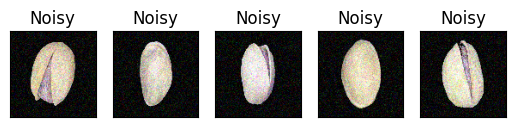

In [12]:
n=5
for i in range(n):
  ax = plt.subplot(3, n, i + 1 + n)
  plt.imshow(x_train_noisy[i])
  plt.title("Noisy")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

In [13]:
x_train_noisy.shape

(859, 100, 100, 3)

#### Membangun baseline model berdasarkan arsitektur yang telah diberikan.

In [14]:
model_baseline = Sequential()

# Input layer
model_baseline.add(InputLayer(input_shape=(100, 100, 3)))

# Encoder
model_baseline.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_baseline.add(MaxPooling2D((2, 2), padding='same'))
model_baseline.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_baseline.add(MaxPooling2D((2, 2), padding='same'))

# Decoder
model_baseline.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_baseline.add(UpSampling2D((2, 2)))
model_baseline.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_baseline.add(UpSampling2D((2, 2)))
model_baseline.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model_baseline.compile(optimizer='adam', loss='mse')
model_baseline.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        36928     
                                                                 
 up_sampling2d (UpSampling2D  (None, 50, 50, 64)       0

In [15]:
model_baseline.fit(x_train_noisy, X_train, validation_data=(x_test_noisy, X_test), epochs=20, batch_size=32)

Epoch 1/20
27/27 [==============================] - 7s 45ms/step - loss: 0.0795 - val_loss: 0.0130
Epoch 2/20
27/27 [==============================] - 1s 21ms/step - loss: 0.0150 - val_loss: 0.0158
Epoch 3/20
27/27 [==============================] - 1s 21ms/step - loss: 0.0125 - val_loss: 0.0089
Epoch 4/20
27/27 [==============================] - 1s 21ms/step - loss: 0.0055 - val_loss: 0.0036
Epoch 5/20
27/27 [==============================] - 1s 20ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 6/20
27/27 [==============================] - 1s 20ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 7/20
27/27 [==============================] - 1s 21ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 8/20
27/27 [==============================] - 1s 21ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 9/20
27/27 [==============================] - 1s 21ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 10/20
27/27 [==============================] - 1s 21ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 11/

In [16]:
pred_baseline = model_baseline.predict(x_test_noisy)

4/4 [==============================] - 0s 7ms/step


Test Images


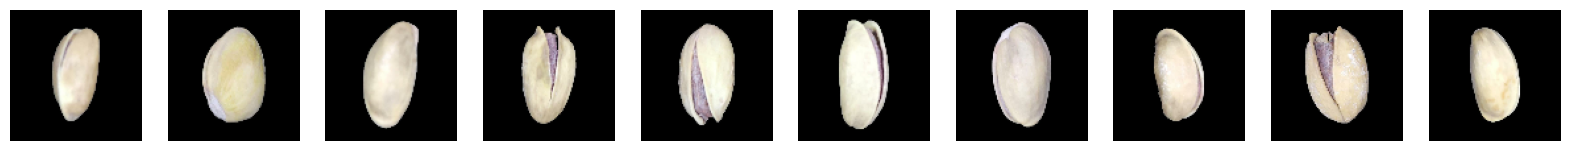

Test Images with Noise


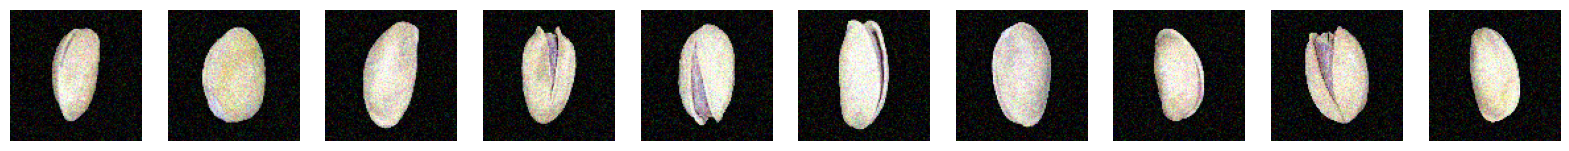

Reconstruction of Noisy Test Images


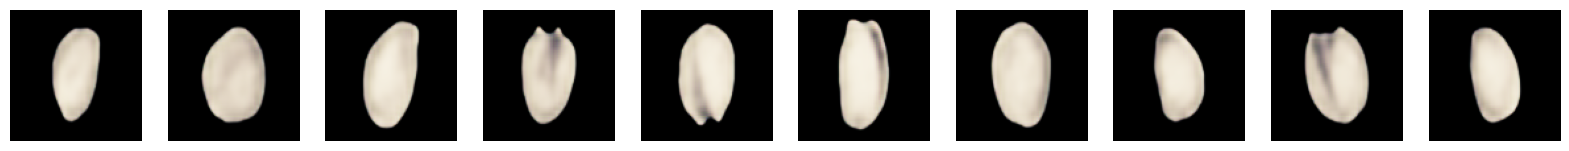

In [17]:
start_idx = 0
end_idx = 10

plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(start_idx, end_idx):
    plt.subplot(2, 10, i - start_idx + 1)
    plt.imshow(X_test[i])
    if 'y_test' in globals():
        plt.title(f"(Label: {y_test[i]})")
    plt.axis('off')
plt.show()

plt.figure(figsize=(20, 4))
print("Test Images with Noise")
for i in range(start_idx, end_idx):
    plt.subplot(2, 10, i - start_idx + 1)
    plt.imshow(x_test_noisy[i])
    plt.axis('off')
plt.show()

plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(start_idx, end_idx):
    plt.subplot(2, 10, i - start_idx + 1)
    plt.imshow(pred_baseline[i])
    plt.axis('off')
plt.show()

#### Pada modified model, saya melakukan beberapa perubahan pada konvolusi serta filter, dengan harapan model yang dihasilkan menjadi lebih baik. Pada bagian bottleneck, saya juga membuat filternya menjadi 1024, hal tersebut bertujuan agar model dapat memahami lebih banyak fitur pada gambar tersebut.

In [18]:
model_modified = Sequential()
model_modified.add(InputLayer(input_shape=(100, 100, 3)))

# Encoder
model_modified.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_modified.add(MaxPooling2D((2, 2), padding='same'))

model_modified.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_modified.add(MaxPooling2D((2, 2), padding='same'))

# Bottleneck
model_modified.add(Conv2D(1024, (3, 3), activation='relu', padding='same'))

# Decoder
model_modified.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_modified.add(UpSampling2D((2, 2)))

model_modified.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_modified.add(UpSampling2D((2, 2)))


model_modified.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model_modified.compile(optimizer='adam', loss='mse')
model_modified.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 100, 100, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 50, 50, 256)       147712    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 25, 256)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 25, 25, 1024)      2360320   
                                                                 
 conv2d_8 (Conv2D)           (None, 25, 25, 256)      

In [19]:
model_modified.fit(x_train_noisy, X_train, validation_data=(x_test_noisy, X_test), epochs=20, batch_size=32)

Epoch 1/20
27/27 [==============================] - 14s 310ms/step - loss: 0.0330 - val_loss: 0.0051
Epoch 2/20
27/27 [==============================] - 3s 99ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 3/20
27/27 [==============================] - 3s 99ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 4/20
27/27 [==============================] - 3s 100ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 5/20
27/27 [==============================] - 3s 99ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 6/20
27/27 [==============================] - 3s 99ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 7/20
27/27 [==============================] - 3s 99ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 8/20
27/27 [==============================] - 3s 100ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 9/20
27/27 [==============================] - 3s 100ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 10/20
27/27 [==============================] - 3s 100ms/step - loss: 0.0014 - val_loss: 0.0012
Epo

In [20]:
pred_modified = model_modified.predict(x_test_noisy)

4/4 [==============================] - 0s 26ms/step


Test Images


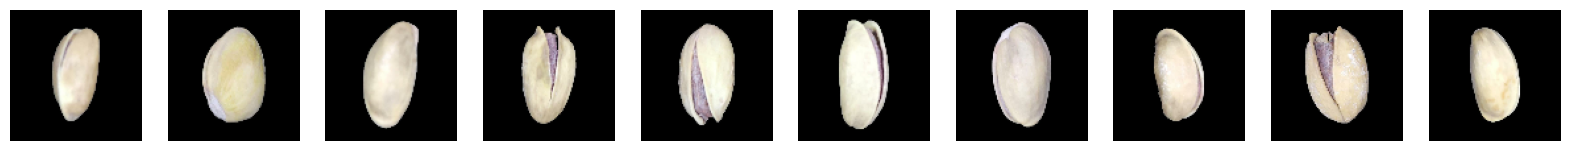

Test Images with Noise


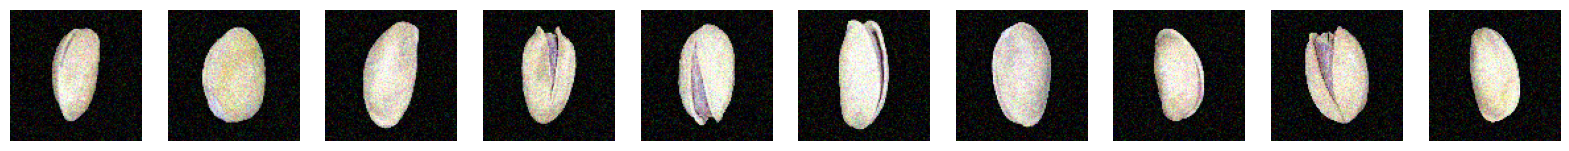

Reconstruction of Noisy Test Images


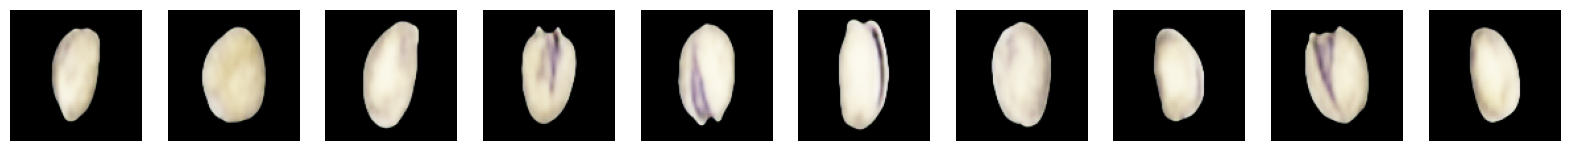

In [21]:
start_idx = 0
end_idx = 10

plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(start_idx, end_idx):
    plt.subplot(2, 10, i - start_idx + 1)
    plt.imshow(X_test[i])
    if 'y_test' in globals():
        plt.title(f"(Label: {y_test[i]})")
    plt.axis('off')
plt.show()

plt.figure(figsize=(20, 4))
print("Test Images with Noise")
for i in range(start_idx, end_idx):
    plt.subplot(2, 10, i - start_idx + 1)
    plt.imshow(x_test_noisy[i])
    plt.axis('off')
plt.show()

plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(start_idx, end_idx):
    plt.subplot(2, 10, i - start_idx + 1)
    plt.imshow(pred_modified[i])
    plt.axis('off')
plt.show()

#### Membuat function untuk menampilkan nilai SSIM.

In [22]:
def calculate_ssim(X_test, pred):
    ssim_scores = []

    for i in range(X_test.shape[0]):
        score = ssim(X_test[i], pred[i], data_range=1.0, channel_axis=-1)
        ssim_scores.append(score)

    ssim_scores = np.array(ssim_scores)

    min_ssim = np.min(ssim_scores)
    max_ssim = np.max(ssim_scores)
    avg_ssim = np.mean(ssim_scores)

    print(f"Minimum SSIM: {min_ssim:.4f}")
    print(f"Maximum SSIM: {max_ssim:.4f}")
    print(f"Average SSIM: {avg_ssim:.4f}")


In [24]:
print("Baseline Model")
calculate_ssim(X_test, pred_baseline)
print("")
print("Modified Model")
calculate_ssim(X_test, pred_modified)

Baseline Model
Minimum SSIM: 0.8587
Maximum SSIM: 0.9666
Average SSIM: 0.9250

Modified Model
Minimum SSIM: 0.9134
Maximum SSIM: 0.9793
Average SSIM: 0.9502


#### Berdasarkan hasil evaluasi SSIM pada gambar di atas, dapat disimpulkan bahwa model yang telah dimodifikasi memberikan hasil yang lebih baik dibandingkan model baseline. Nilai rata-rata SSIM pada model awal adalah 0.9250, sedangkan pada model modifikasi meningkat menjadi 0.9502. Ini menunjukkan bahwa hasil yang dihasilkan oleh model modifikasi secara keseluruhan lebih mirip dengan gambar aslinya. Selain itu, nilai SSIM terendah pada model modifikasi juga jauh lebih tinggi, yaitu 0.9134 dibandingkan 0.8587 pada model baseline. Ini menandakan bahwa model modifikasi lebih konsisten dalam menghasilkan hasil yang baik, bahkan pada kasus terburuk sekalipun. Nilai SSIM tertinggi juga sedikit lebih tinggi pada model modifikasi, yaitu 0.9793 dibandingkan 0.9666 pada model awal. Secara keseluruhan, model yang dimodifikasi tidak hanya lebih baik secara rata-rata, tetapi juga lebih stabil dan andal dalam menghasilkan gambar yang mendekati aslinya. Hal ini menunjukkan bahwa perubahan arsitektur yang dilakukan memberikan dampak positif terhadap kualitas hasil model.